In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  app.launch_new_instance()


In [2]:
tfidf_path = '../../data/tfidf_merged_chs_20210915_nocrossover/'

In [3]:
lda_path = '../../data/lda_merged_chs_20210915_no_crossover/'

In [4]:
# fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]

In [5]:
# fandom_list

In [6]:
# df = pd.read_csv(os.path.join(lda_path,'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv'), sep = '\t')

In [7]:
# len(df)

In [8]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [9]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [10]:
def create_normed_dfs(df, field):

#     turn into z scores
    df[field] = np.log(df[field]+1)
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].dropna()
    df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [11]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
    return dic

In [12]:
def generate_res(path, fandom, nov_field, suc_field, metric):
    if nov_field == 'Cos':
        df = pd.read_csv(os.path.join(path,fandom + \
                                  '_temporal_tfidf_cos_merged_chapters_no_crossover_no_sample_20210915.tsv'), sep = '\t')
    elif nov_field == 'JSD':
        df = pd.read_csv(os.path.join(path,fandom + \
                                  '_lda_with_dist_merged_chs_no_crossover_20210915.tsv'), sep = '\t')
    df = create_normed_dfs(df, suc_field)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df[[nov_field, suc_field]].dropna()

    df = df.sort_values(by = nov_field)
    df = df.sort_values(by = suc_field)
    dic = create_dict(df, nov_field, suc_field, metric)

    return dic
    

In [13]:
def generate_dics(fandom, suffix='None'):
    tfidf_kudos_dict_var = generate_res(tfidf_path, fandom, 'Cos', 'Kudos', 'var')
    tfidf_hits_dict_var = generate_res(tfidf_path, fandom, 'Cos', 'Hits', 'var')
    tfidf_comments_dict_var = generate_res(tfidf_path, fandom, 'Cos', 'Comments', 'var')
    tfidf_bookmarks_dict_var = generate_res(tfidf_path,  fandom,'Cos', 'Bookmarks', 'var')
     
    tfidf_kudos_dict_ave = generate_res(tfidf_path,  fandom,'Cos', 'Kudos', 'ave')
    tfidf_hits_dict_ave = generate_res(tfidf_path,  fandom,'Cos', 'Hits', 'ave')
    tfidf_comments_dict_ave = generate_res(tfidf_path, fandom, 'Cos', 'Comments', 'ave')
    tfidf_bookmarks_dict_ave = generate_res(tfidf_path,  fandom,'Cos', 'Bookmarks', 'ave')
    
    lda_kudos_dict_var = generate_res(lda_path, fandom, 'JSD', 'Kudos', 'var')
    lda_hits_dict_var = generate_res(lda_path, fandom, 'JSD', 'Hits', 'var')
    lda_comments_dict_var = generate_res(lda_path, fandom, 'JSD', 'Comments', 'var')
    lda_bookmarks_dict_var = generate_res(lda_path,  fandom,'JSD', 'Bookmarks', 'var')
    
    lda_kudos_dict_ave = generate_res(lda_path, fandom, 'JSD', 'Kudos', 'ave')
    lda_hits_dict_ave = generate_res(lda_path, fandom, 'JSD', 'Hits', 'ave')
    lda_comments_dict_ave = generate_res(lda_path, fandom, 'JSD', 'Comments', 'ave')
    lda_bookmarks_dict_ave = generate_res(lda_path,  fandom,'JSD', 'Bookmarks', 'ave')
    
    return tfidf_kudos_dict_var, tfidf_hits_dict_var, tfidf_comments_dict_var, \
            tfidf_bookmarks_dict_var, tfidf_kudos_dict_ave, tfidf_hits_dict_ave,\
            tfidf_comments_dict_ave, tfidf_bookmarks_dict_ave , lda_kudos_dict_var,\
            lda_hits_dict_var, lda_comments_dict_var, lda_bookmarks_dict_var,\
            lda_kudos_dict_ave, lda_hits_dict_ave, lda_comments_dict_ave, lda_bookmarks_dict_ave

In [14]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [15]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [16]:
fandom_list = [
 'supernatural',
]

supernatural


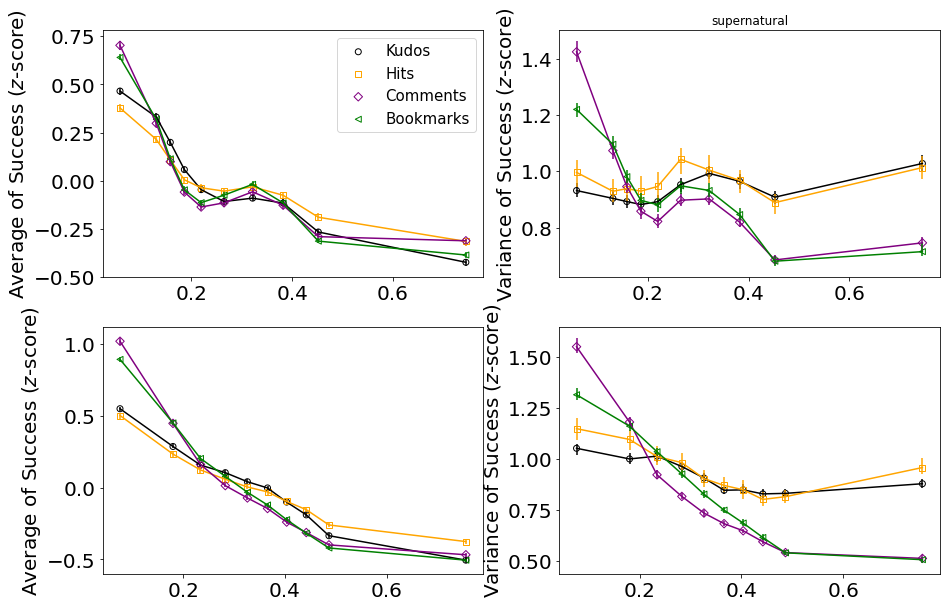

In [17]:
for fandom in fandom_list:
    print(fandom)
    tfidf_kudos_dict_var, tfidf_hits_dict_var, tfidf_comments_dict_var, \
    tfidf_bookmarks_dict_var, tfidf_kudos_dict_ave, tfidf_hits_dict_ave,\
    tfidf_comments_dict_ave, tfidf_bookmarks_dict_ave , lda_kudos_dict_var,\
    lda_hits_dict_var, lda_comments_dict_var, lda_bookmarks_dict_var,\
    lda_kudos_dict_ave, lda_hits_dict_ave, lda_comments_dict_ave, lda_bookmarks_dict_ave = \
                                        generate_dics(fandom)
    fig, axes = plt.subplots(2,2,figsize = (15,10))
    x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
    axes[0][0].errorbar(x, y, yerr=err, color='black')
    axes[0][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

    x, y, err = extract_plot_vals(tfidf_hits_dict_ave)
    axes[0][0].errorbar(x, y, yerr=err, c='orange')
    axes[0][0].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

    x, y, err = extract_plot_vals(tfidf_comments_dict_ave)
    axes[0][0].errorbar(x, y, yerr=err, c='purple')
    axes[0][0].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

    x, y, err = extract_plot_vals(tfidf_bookmarks_dict_ave)
    axes[0][0].errorbar(x, y, yerr=err, c='green')
    axes[0][0].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

    axes[0][0].legend(prop={'size': 15})
    axes[0][0].set_ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
    axes[0][0].tick_params(labelsize=20)

    x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
    axes[0][1].errorbar(x, y, yerr=err, color='black')
    axes[0][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

    x, y, err = extract_plot_vals(tfidf_hits_dict_var)
    axes[0][1].errorbar(x, y, yerr=err, c='orange')
    axes[0][1].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

    x, y, err = extract_plot_vals(tfidf_comments_dict_var)
    axes[0][1].errorbar(x, y, yerr=err, c='purple')
    axes[0][1].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

    x, y, err = extract_plot_vals(tfidf_bookmarks_dict_var)
    axes[0][1].errorbar(x, y, yerr=err, c='green')
    axes[0][1].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
    axes[0][1].set_ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)
    # plt.legend()
    axes[0][1].tick_params(labelsize=20)
    axes[0][1].set_title(fandom)
    
    
    x, y, err = extract_plot_vals(lda_kudos_dict_ave)
    axes[1][0].errorbar(x, y, yerr=err, color='black')
    axes[1][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

    x, y, err = extract_plot_vals(lda_hits_dict_ave)
    axes[1][0].errorbar(x, y, yerr=err, c='orange')
    axes[1][0].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

    x, y, err = extract_plot_vals(lda_comments_dict_ave)
    axes[1][0].errorbar(x, y, yerr=err, c='purple')
    axes[1][0].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

    x, y, err = extract_plot_vals(lda_bookmarks_dict_ave)
    axes[1][0].errorbar(x, y, yerr=err, c='green')
    axes[1][0].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

    # plt.legend(prop={'size': 15})
    axes[1][0].set_ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
    axes[1][0].tick_params(labelsize=20)


    x, y, err = extract_plot_vals(lda_kudos_dict_var)
    axes[1][1].errorbar(x, y, yerr=err, color='black')
    axes[1][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

    x, y, err = extract_plot_vals(lda_hits_dict_var)
    axes[1][1].errorbar(x, y, yerr=err, c='orange')
    axes[1][1].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

    x, y, err = extract_plot_vals(lda_comments_dict_var)
    axes[1][1].errorbar(x, y, yerr=err, c='purple')
    axes[1][1].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

    x, y, err = extract_plot_vals(lda_bookmarks_dict_var)
    axes[1][1].errorbar(x, y, yerr=err, c='green')
    axes[1][1].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
    axes[1][1].set_ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)
    axes[1][1].tick_params(labelsize=20)

In [18]:
df = pd.read_csv(tfidf_path + 'supernatural_temporal_tfidf_cos_merged_chapters_no_crossover_no_sample_20210915.tsv', sep='\t')

In [19]:
df.head(2)

,index,AdditionalTags,ArchiveWarnings,Author,Bookmarks,Category,Chapters,Characters,Fandoms,Hits,...,Rating,Relationship,Title,Words,PublishDate,UpdateDate,CompleteDate,Comments,URL,Cos
0,911,AU after season 3,No Archive Warnings Apply,jonny_vrm,215,M/M,1,"Dean Winchester, Sam Winchester, Bobby Singer",['Supernatural'],11728.0,...,Explicit,Dean Winchester/Sam Winchester,Hit the Ground Crawling,28122.0,2009-07-29,NaN,2009-07-29,27,http://archiveofourown.org/works/92140?view_ad...,0.095805
1,1835,"AU, lgbtfest, FTM Dean",No Archive Warnings Apply,Zooey_Glass,27,Gen,1,"Sam Winchester, Dean Winchester",['Supernatural'],0.0,...,Mature,NaN,The violet hour,5360.0,2009-07-16,NaN,2009-07-16,13,http://archiveofourown.org/works/5528?view_adu...,0.330360


In [20]:
len(df)

88755

In [27]:
df_mid = df[df['Cos'] > 0.25]
df_mid = df_mid[df_mid['Cos'] < 0.4]

In [28]:
len(df_mid)

22662

In [29]:
np.average(df_mid.Kudos)

75.13798429088342

In [35]:
df_low = df[df['Cos'] < 0.25] 
df_low = df_low[df_low['Cos'] > 0.2] 

In [36]:
len(df_low)

11195

In [37]:
np.average(df_low.Kudos)

74.42706565430996

In [32]:
df_high = df[df['Cos'] > 0.4]

In [34]:
np.average(df_high.Kudos)

53.078033055313924

In [80]:
df_mid.sort_values(by='Kudos', ascending=False).head()

,index,AdditionalTags,ArchiveWarnings,Author,Bookmarks,Category,Chapters,Characters,Fandoms,Hits,...,Rating,Relationship,Title,Words,PublishDate,UpdateDate,CompleteDate,Comments,URL,Cos
1621,39567,"First Time, Plot What Plot, Wet Dream, Frottag...",No Archive Warnings Apply,Annie D,205,M/M,1,"Castiel, Dean Winchester, Sam Winchester",['Supernatural'],0.0,...,Explicit,Castiel/Dean Winchester,Dean Doesn\'t Listen to Eurythmics,1941.0,2010-03-24,NaN,2010-03-24,37,http://archiveofourown.org/works/74460?view_ad...,0.366830
41393,56479,"Masturbation, Porn Watching, Anal Play, Shamel...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,205,M/M,18,NaN,['Supernatural'],102815.0,...,Explicit,Castiel/Dean Winchester,A Room Of One\'s Own,94113.0,2014-05-16,NaN,2014-05-18,70,http://archiveofourown.org/works/1417834/chapt...,0.286639
39596,56475,"Masturbation, Porn Watching, Anal Play, Shamel...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,205,M/M,18,NaN,['Supernatural'],102811.0,...,Explicit,Castiel/Dean Winchester,A Room Of One\'s Own,94113.0,2014-04-05,NaN,2014-05-18,122,http://archiveofourown.org/works/1417834/chapt...,0.284728
39597,56476,"Masturbation, Porn Watching, Anal Play, Shamel...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,205,M/M,18,NaN,['Supernatural'],102812.0,...,Explicit,Castiel/Dean Winchester,A Room Of One\'s Own,94113.0,2014-04-18,NaN,2014-05-18,30,http://archiveofourown.org/works/1417834/chapt...,0.363542
39598,56477,"Masturbation, Porn Watching, Anal Play, Shamel...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,205,M/M,18,NaN,['Supernatural'],102813.0,...,Explicit,Castiel/Dean Winchester,A Room Of One\'s Own,94113.0,2014-04-24,NaN,2014-05-18,216,http://archiveofourown.org/works/1417834/chapt...,0.300986


In [ ]:
, 'AdditionalTags', 'ArchiveWarnings', 'Author',
       'Bookmarks', 'Category', 'Chapters', 'Characters', 'Fandoms',
       , 'Kudos', 'Language', 'Rating', 'Relationship', 'Title',
       'Words', 'PublishDate', 'UpdateDate', 'CompleteDate', 'Comments',
       'URL', 'Cos']

In [42]:
df.columns.values

array(['index', 'AdditionalTags', 'ArchiveWarnings', 'Author',
       'Bookmarks', 'Category', 'Chapters', 'Characters', 'Fandoms',
       'Hits', 'Kudos', 'Language', 'Rating', 'Relationship', 'Title',
       'Words', 'PublishDate', 'UpdateDate', 'CompleteDate', 'Comments',
       'URL', 'Cos'], dtype=object)

In [90]:
grp = df.groupby(['AdditionalTags', 'ArchiveWarnings', 'Author', 'Category',
					'Chapters', 'Characters', 'Fandoms', 'Kudos', 'Language', 
					'Rating', 'Relationship', 'Title', 'Words'], dropna=False)\
			.agg({ 'Comments': sum, 'URL': np.random.choice})\
			.reset_index()

In [91]:
len(grp)

87866

In [85]:
grp[grp['Author']=='NorthernSparrow']

,AdditionalTags,ArchiveWarnings,Author,Category,Chapters,Characters,Fandoms,Kudos,Language,Rating,Relationship,Title,Words,Comments,URL
12572,"Angst, Castiel Whump, Hurt Castiel, Emotional ...","Graphic Depictions Of Violence, Major Characte...",NorthernSparrow,M/M,35,"Castiel, Dean Winchester, Sam Winchester, Crow...",['Supernatural'],1305.0,English,Mature,Castiel/Dean Winchester,Into The Fire,258638.0,1314,http://archiveofourown.org/works/4080676/chapt...
13488,"Angst, Hurt/Comfort, Case Fic, Amnesiac Dean, ...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,Gen,8,"Castiel, Dean Winchester, Sam Winchester, Crow...",['Supernatural'],42.0,English,General Audiences,NaN,Forgotten [podfic],987.0,52,http://archiveofourown.org/works/6027858/chapt...
13813,"Angst, Other Additional Tags to Be Added, Amne...",No Archive Warnings Apply,NorthernSparrow,M/M,14,"Castiel, Dean Winchester, Sam Winchester, Clai...",['Supernatural'],1337.0,English,Explicit,Castiel/Dean Winchester,The Most Important Thing,94461.0,457,http://archiveofourown.org/works/3431636/chapt...
38470,"Friendship/Love, Family, Angst, Hurt Castiel, ...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,M/M,45,"Castiel, Dean Winchester, Sam Winchester, Crow...",['Supernatural'],1669.0,English,Mature,"Castiel/Dean Winchester, Sam/Original Female C...",Flight,319744.0,1717,http://archiveofourown.org/works/1749230/chapt...
41368,"Human Castiel, Lonely Castiel, Poverty, Loneli...",No Archive Warnings Apply,NorthernSparrow,M/M,2,"Castiel, Dean Winchester",['Supernatural'],511.0,English,Explicit,Castiel/Dean Winchester,Twenty Dollars,15337.0,81,http://archiveofourown.org/works/5588509/chapt...
43637,"Hurt/Comfort, Sick Castiel, Diary/Journal, Hum...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,Gen,11,"Castiel, Dean Winchester, Sam Winchester",['Supernatural'],1215.0,English,Teen And Up Audiences,Castiel/Dean Winchester,A Winter\'s Tale,64316.0,305,http://archiveofourown.org/works/2654327/chapt...
47642,"Masturbation, Porn Watching, Anal Play, Shamel...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,M/M,18,NaN,['Supernatural'],5690.0,English,Explicit,Castiel/Dean Winchester,A Room Of One\'s Own,94113.0,462,http://archiveofourown.org/works/1417834/chapt...
62675,"Sick Castiel, Guilty Dean, Season/Series 09, O...",No Archive Warnings Apply,NorthernSparrow,M/M,1,"Castiel, Dean Winchester, Sam Winchester",['Supernatural'],965.0,English,Explicit,Castiel/Dean Winchester,A Close Shave,8658.0,53,http://archiveofourown.org/works/3090167?view_...
66772,"Team Free Will, Castiel & Dean Winchester Frie...",Creator Chose Not To Use Archive Warnings,NorthernSparrow,Gen,22,"Castiel, Dean Winchester, Sam Winchester, Crow...",['Supernatural'],200.0,English,Teen And Up Audiences,NaN,Broken,136055.0,213,http://archiveofourown.org/works/2790431/chapt...


In [78]:
grp.sort_values(by='Kudos', ascending=False).head()

,AdditionalTags,ArchiveWarnings,Author,Bookmarks,Category,Chapters,Characters,Fandoms,Kudos,Language,Rating,Relationship,Title,Words,Comments,URL
23859,"DeanCas Big Bang, Twist and Shout, AU","Graphic Depictions Of Violence, Major Characte...",standbyme,206,F/MM/M,13,"Dean Winchester, Castiel, Sam Winchester, Balt...",['Supernatural'],21350.0,English,Explicit,"Dean/Castiel, Sam/Jess, Balthazar/Castiel",Twist and Shout,97997.0,373,http://archiveofourown.org/works/537876/chapte...
23858,"DeanCas Big Bang, Twist and Shout, AU","Graphic Depictions Of Violence, Major Characte...",standbyme,0,F/MM/M,13,"Dean Winchester, Castiel, Sam Winchester, Balt...",['Supernatural'],21350.0,English,Explicit,"Dean/Castiel, Sam/Jess, Balthazar/Castiel",Twist and Shout,97997.0,30,http://archiveofourown.org/works/537876/chapte...
33886,"First Time, Plot What Plot, Wet Dream, Frottag...",No Archive Warnings Apply,Annie D,205,M/M,1,"Castiel, Dean Winchester, Sam Winchester",['Supernatural'],9473.0,English,Explicit,Castiel/Dean Winchester,Dean Doesn\'t Listen to Eurythmics,1941.0,37,http://archiveofourown.org/works/74460?view_ad...
82774,NaN,Creator Chose Not To Use Archive Warnings,rageprufrock,207,M/M,1,NaN,['Supernatural'],8868.0,English,Explicit,NaN,The Girlfriend Experience,15393.0,20,http://archiveofourown.org/works/91894?view_ad...
5470,"Alternate Universe - College/University, Tatto...",No Archive Warnings Apply,beastofthesky,215,M/M,1,"Castiel, Dean Winchester, Sam Winchester, Gabr...",['Supernatural'],7798.0,English,Mature,"Castiel/Dean Winchester, Gabriel/Sam Winchester",An Exercise In \'Worthless\',26547.0,33,http://archiveofourown.org/works/535676?view_a...


In [72]:
grp.size()

AdditionalTags                                                                                                                                                                                                               ArchiveWarnings                            Author             Bookmarks  Category  Chapters  Characters                                                                                 Fandoms           Kudos  Language  Rating                 Relationship                                             Title                               Words  
!!!!, Presents, Christmas Fluff, Christmas, Christmas Presents, Kissing, Sam Ships It, Established Relationship, Eggnog, Emotions, omg, happiness, !!!, Human Castiel                                                        Creator Chose Not To Use Archive Warnings  Colordrained       1          M/M       1         Dean Winchester, Castiel, Sam Winchester                                                   ['Supernatural']  32.0   Englis